# Принятие решений в бизнесе на основе данных<a class="tocSkip">

**Цель проекта - изучение гипотез для увеличения выручки интернет-магазина. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.**

### Оглавление<a class="tocSkip">

[Загрузка и изучение данных](#open)

[Подготовка данных](#preprocessing)

[Часть 1. Приоритизация гипотез.](#part1)

- [Фреймворк ICE](#ice)

- [Фреймворк RICE](#rice)

[Часть 2. Анализ A/B-теста](#part2)

- [Построение графика кумулятивной выручки по группам](#step1)

- [Построение графика кумулятивного среднего чека по группам](#step2)

- [График относительного изменения кумулятивного среднего чека группы B к группе A](#step3)

- [Построение графика кумулятивной конверсии по группам](#step4)

- [Построение графика относительного изменения кумулятивной конверсии группы B к группе A](#step5)

- [Tочечный график количества заказов по пользователям](#step6)

- [Рассчет 95-го и 99-го перцентияи количества заказов на пользователя](#step7)

- [Построение точечного графика стоимостей заказов](#step8)

- [Расчет 95-го и 99-го перцентиля стоимости заказов](#step9)

- [Расчет статистической значимости различий в конверсии между группами по «сырым» данным](#step10)

- [Определение статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#step11)

- [Рассчет статистической значимости различий в конверсии между группами по «очищенным» данным](#step12)

- [Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#step13)

- [Pешение по результатам теста](#step14)

<a id="open"></a>
## Загрузка и изучение данных<a class="tocSkip">

In [77]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('bmh')
from scipy import stats
import seaborn as sns

ImportError: cannot import name 'register_matplotlib_converter' from 'pandas.plotting' (/opt/conda/lib/python3.7/site-packages/pandas/plotting/__init__.py)

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [3]:
hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders = pd.read_csv('/datasets/orders.csv')

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Данные загружены, перейдем к предобработке.**

<a id="preprocessing"></a>
## Подготовка данных<a class="tocSkip">

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
orders.duplicated().sum()

0

In [14]:
visitors.duplicated().sum()

0

**Пропуски и дубликаты не обнаружены, можем переходить к анализу данных**

In [15]:
visitors.groupby('group')['visitors'].count()

group
A    31
B    31
Name: visitors, dtype: int64

**Группы содержат равное количество участников.**

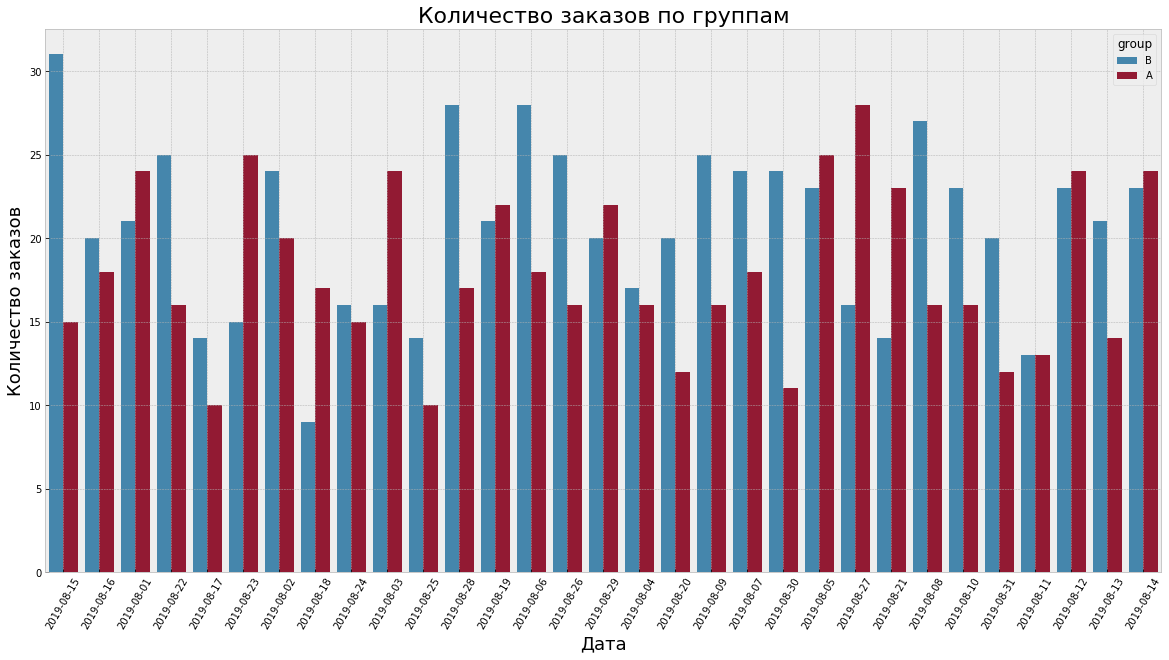

In [16]:
plt.figure(figsize=(20, 10))
sns.countplot(x='date', data=orders, hue='group') 
plt.xticks(rotation=60)
plt.title("Количество заказов по группам",fontsize=22)
plt.xlabel("Дата", fontsize=18)
plt.ylabel("Количество заказов", fontsize=18)
plt.grid(True)
plt.show() 

In [17]:
orders.groupby(['date','group'])['transactionId'].count().isnull().sum()

0

**Пользователи каждой из групп представлены во все дни эксперимента.**

<a id="part1"></a>
## Часть 1. Приоритизация гипотез.<a class="tocSkip">

<a id="ice"></a>
- ### Фреймворк ICE<a class="tocSkip"><a class="tocSkip">

$$ICE = \frac{Impact * Confidence}{Efforts}$$

**Для приоритизации гипотез применим фреймворк ICE. Отсортируем их по убыванию приоритета.**

In [18]:
hypothesis['ice'] = (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']).round(1)

In [19]:
hypothesis.sort_values(by='ice', ascending =False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


**Данный метод показывает наибольший приоритет для гипотез 8, 0 и 7.**

<a id="rice"></a>
- ### Фреймворк RICE<a class="tocSkip">

**Применим фреймворк RICE. Отсортируем гипотезы по убыванию приоритета.**

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [20]:
hypothesis['rice'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']\
/ hypothesis['Efforts']

In [21]:
hypothesis.sort_values(by='rice', ascending =False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


**В результате применения фреймворка RICE вперед со значительным отрывом вышла гипотеза 7, за ней 2, 0 и 6. Применение критерия Reach (охват) сделало вариант 8 неактуальным, т.к. он применим "только раз в году"**

<a id="part2"></a>
## Часть 2. Анализ A/B-теста<a class="tocSkip">

<a id="step1"></a>
- ### Построение графика кумулятивной выручки по группам<a class="tocSkip">

In [22]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [23]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))


**Создаем массив уникальных пар значений дат и групп теста**

In [24]:
datesGroups = orders[['date','group']].drop_duplicates()

**Получаем агрегированные кумулятивные по дням данные о заказах** 

In [25]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique,\
'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [26]:
ordersAggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']

**Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина**

In [27]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),\
                                       axis=1).sort_values(by=['date','group'])

**Объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия**

In [28]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [29]:
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


**Создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А**

In [30]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

**Создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B**

In [31]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

**Строим графики кумулятивной выручки групп А и В**

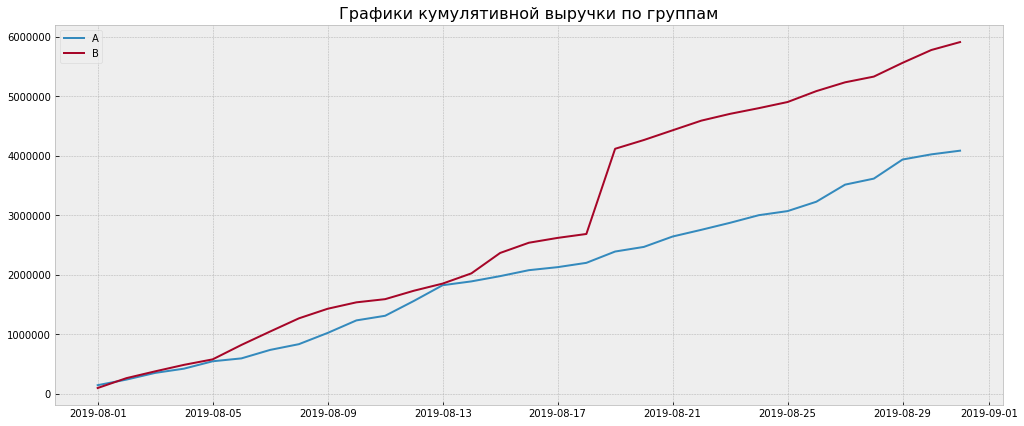

In [78]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(17,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Графики кумулятивной выручки по группам', fontsize= 16)
plt.grid(True)
plt.legend()

**На графиках мы видим устойчивый рост выручки в обеих группах, однако группа В заметно опережает группу А, кроме того в группе В случился резкий скачек в конце августа, вероятно - крупный заказ.**

<a id="step2"></a>
- ### Построение графика кумулятивного среднего чека по группам<a class="tocSkip">

**Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:**

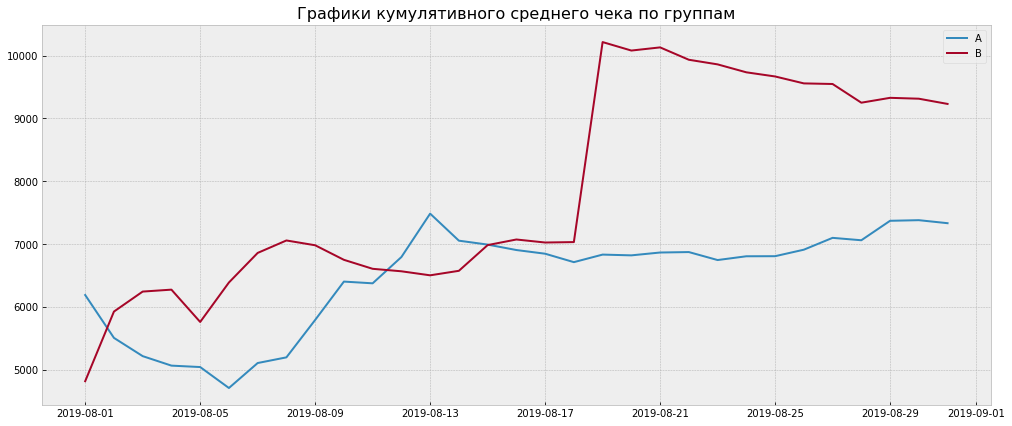

In [33]:
plt.figure(figsize=(17,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.grid(True)
plt.title('Графики кумулятивного среднего чека по группам', fontsize= 16)
plt.legend()

**Обе групп в целом показывают рост среднего чека. В группе А, вероятно после выброса в начале теста, произошло падение, затемрезкий рост, небольшой пик и, фактически, стабилизация значений среднего чека несколько выше 7000 в середине теста. Группа В волнообразно росла до второй половины августа, потом, как и на предыдущемм графике, резкий скачек и плавное снижение. В итоге к концу теста средний чек группы В более чем на 2000 выше, чем у группы А.**

<a id="step3"></a>
- ### График относительного изменения кумулятивного среднего чека группы B к группе A<a class="tocSkip">

**Собираем данные в одном датафрейме**

In [34]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date',\
                                                   how='left', suffixes=['A', 'B'])

**Строим отношение средних чеков**

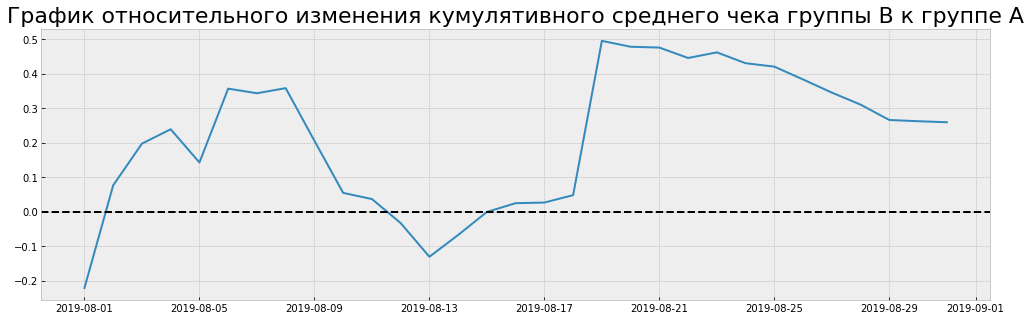

In [75]:
plt.figure(figsize=(17,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']\
/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']\
/mergedCumulativeRevenue['ordersA'])-1)
plt.grid(True)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize= 16)
plt.axhline(y=0, color='black', linestyle='--')

**Мы видим на графике резкие скачки, - выбросы означающие крупные заказы.**

<a id="step4"></a>
- ### Построение графика кумулятивной конверсии по группам<a class="tocSkip">

**Cчитаем кумулятивную конверсию.**

In [36]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

**Oтделяем данные по группе A и В.**

Text(0.5, 1.0, 'График кумулятивной конверсии по группам')

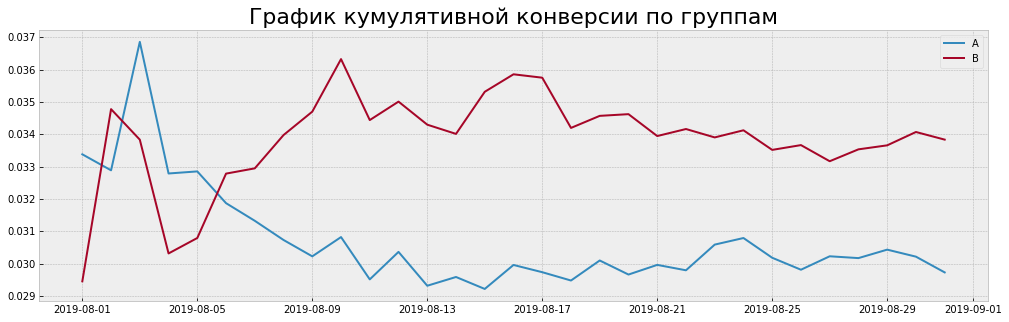

In [37]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(17,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.grid(True)
plt.legend()
plt.title('График кумулятивной конверсии по группам', fontsize= 16)
# задаем масштаб осей
#plt.axis(["2019-04-01", '2019-04-23', 0, 0.015])

**После резких скачков в первой трети теста значения конверсий обеих групп стабилизировались. Более высокую конверсию мы видим в группе В.**

<a id="step5"></a>
- ### Построение графика относительного изменения кумулятивной конверсии группы B к группе A<a class="tocSkip">

In [38]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date',\
how='left', suffixes=['A', 'B'])

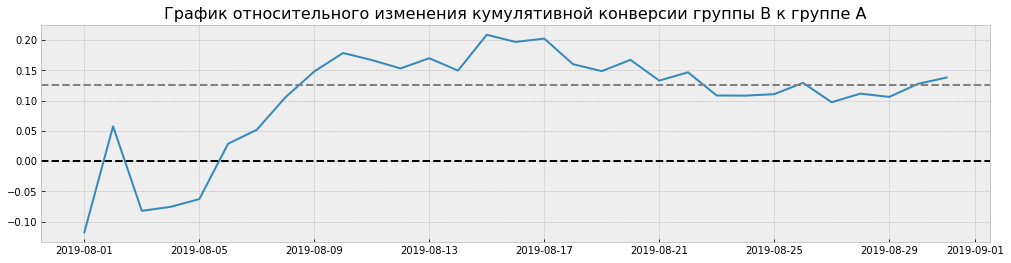

In [76]:
plt.figure(figsize=(17,4))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']\
/mergedCumulativeConversions['conversionA']-1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize= )
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.125, color='grey', linestyle='--')
plt.grid(True)
plt.show()

**Здесь мы видим, что в течении первой недели теста график относительного изменения кумулятивной конверсии группы B к группе A заметно колебался, уходил ниже ноля, затем начался рост. Значения стабилизировались на уровнне 10% - 15%.**

<a id="step6"></a>
- ###  Tочечный график количества заказов по пользователям<a class="tocSkip">

In [40]:
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)

In [41]:
ordersByUsers.columns = ['visitorId', 'orders']

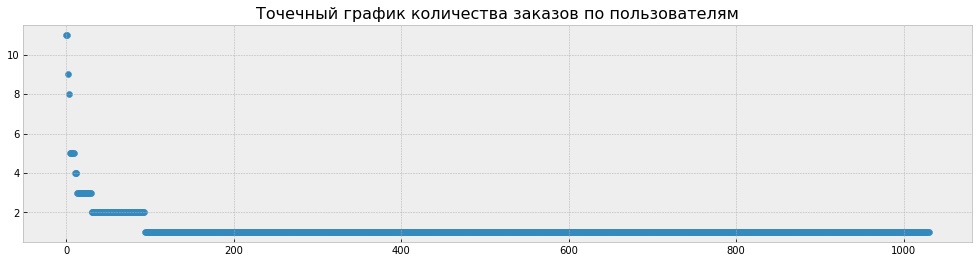

In [42]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(17,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.grid(True)
plt.title('Tочечный график количества заказов по пользователям', fontsize= 16)
plt.show()

**На графике мы видим, что абсолютное большинство покупателей делают лишь разовые заказы. 2 и более заказов делаюь немногие, - посчитаем точнее.**

<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Оличный прием с сортировкой💪</div> <br>

<a id="step7"></a>
- ### Рассчет 95-го и 99-го перцентияи количества заказов на пользователя<a class="tocSkip">

In [43]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


**Не более 5% пользователей оформляли больше чем 2 заказа и только 1% полее 4-х. Будем считать 3 и более заказов аномалией.**

<a id="step8"></a>
- ### Построение точечного графика стоимостей заказов<a class="tocSkip">

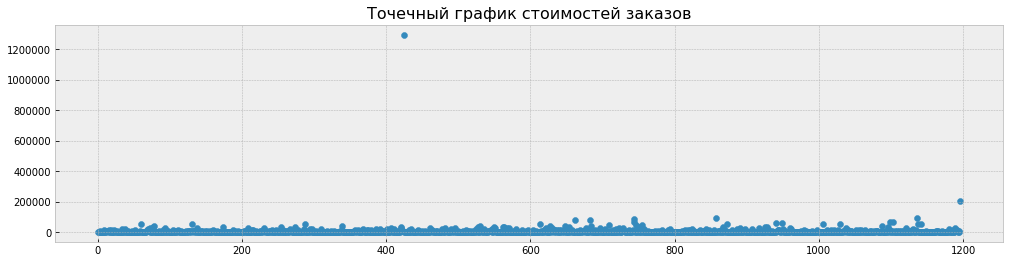

In [44]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(17,4))
plt.scatter(x_values, orders['revenue'])
plt.grid(True)
plt.title('Tочечный график стоимостей заказов', fontsize= 16)
plt.show()

**Данный график показывает, что стоимость почти всех заказов лежит в диапазоне до 5000, однако нужно найти болле точные значения.**

<a id="step9"></a>
- ### Расчет 95-го и 99-го перцентиля стоимости заказов<a class="tocSkip">

In [45]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


**Только 5% клиентов совершают покупки дороже 28000, примем значения выше этого за выбросы.**

<div style="border:solid green 2px; padding: 20px"> <b>Отличная работа</b><br>
Аномалии определены верно👌</div> <br>

<a id="step10"></a>
- ### Расчет статистической значимости различий в конверсии между группами по «сырым» данным<a class="tocSkip">

**Подготовим данные.**

**Найдем количество пользователей в день в группе А**

In [46]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]

In [47]:
visitorsADaily.columns = ['date', 'visitorsPerDateA']

**Определим накопительное количество пользователей в день в группе А.**

In [48]:
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
             .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)

In [49]:
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

**Найдем количество пользователей в день в группе В.**

In [50]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]

In [51]:
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

**Накопительное количество пользователей в день в группе В.**

In [52]:
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
              .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

**Рассчитаем количество заказов и суммарную выручку в день по группе А**

In [53]:
ordersADaily = (orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]
.groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique,'revenue' : 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

**Определим накопительное количество заказов и суммарную выручку в день по группе А.**

In [54]:
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
.agg({'date' : 'max', 'ordersPerDateA' : 'sum', 'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

**Найдем количество заказов и суммарную выручку в день по группе В.**

In [55]:
ordersBDaily = (orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]
.groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'}))
# соответствующие столбцы
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

**Определим накопительное количество заказов и суммарную выручку в день по группе В.**

In [56]:
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
.agg({'date' : 'max','ordersPerDateB' : 'sum','revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

**Объеденим полученные таблицы.**

In [57]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


**Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorId', 'transactionId']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов**

In [58]:
ordersByUsersA = orders[orders['group']=='A'] \
                        .groupby('visitorId', as_index=False) \
                        .agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'transactionId']

In [59]:
ordersByUsersB = orders[orders['group']=='B'] \
                          .groupby('visitorId', as_index=False) \
                          .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'transactionId']

**Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.**

In [60]:
sampleA = pd.concat([ordersByUsersA['transactionId'],pd.Series(0, index=np.arange(data['visitorsPerDateA']\
.sum() - len(ordersByUsersA['transactionId'])), name='transactionId')],axis=0)

In [61]:
sampleB = pd.concat([ordersByUsersB['transactionId'],pd.Series(0, index=np.arange(data['visitorsPerDateB']\
.sum() - len(ordersByUsersB['transactionId'])), name='transactionId')],axis=0)

**Принимаем в качестве нулевой гипотезы "конверсии по группами А и В не различаются", иначе говоря "конверсии равны", что соответсвует правилу: "нулевую гипотезу нужнно формулировать так, чтобы можно было использовать знак равенства". Альтернативная гипотеза - "конверсии по группами А и В различаются".**  

**Определим статистическую значимость различий в конверсии между группами по «сырым» данным.**

In [62]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.008


**P-value ниже 0,05, - отвергаем гипотезу о равенстве конверсий групп А и В**

**Найдем относительный прирост конверсии группы B:**

In [63]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.138


**Относительный прирост конверсии группы В над конверсией группы А составил 13,8%**

<a id="step11"></a>
- ### Определение статистической значимости различий в среднем чеке заказа между группами по «сырым» данным<a class="tocSkip">

**В качестве нулевой гипотезы принимаем утверждение "средние чеки погруппам А и В равны" (используем знак равенства в нулевой гипотезе). Альтернативная - "средние чеки групп А и В различны".**

In [64]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.365


**P-value значительно выше критерия статистической значимости (0,05), следовательно у нас нет оснований отвергнуть гипотезу о равенстве средних чеков по группам.**

In [65]:
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.259


**Относительные различия в среднем чеке между группами В и А - 25,9%** 

<a id="step12"></a>
- ### Рассчет статистической значимости различий в конверсии между группами по «очищенным» данным<a class="tocSkip">

**Cоздадим список аномалий.**

In [66]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['transactionId'] > 2]['visitorId'], 
ordersByUsersB[ordersByUsersB['transactionId'] > 2]['visitorId']], axis = 0)

In [67]:
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

In [68]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], 
                          axis = 0).drop_duplicates().sort_values()
abnormalUsers.head(5)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64

**Создадим переменные по «очищенным» данным.**

In [69]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].\
isin(abnormalUsers))]['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateA'] \
         .sum() - len(ordersByUsersA['transactionId'])), name='transactionId')], axis=0)

In [70]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'] \
.isin(abnormalUsers))]['transactionId'], pd.Series(0, index=np.arange(data['visitorsPerDateB'] \
        .sum() - len(ordersByUsersB['transactionId'])), name='transactionId')], axis=0)

**Как и в случае с «сырыми» данными примем за нулевую гипотезу "конверсии по группами А и В равны", за альтернативную - "конверсии не равны".**

**Применим статистический критерий Манна-Уитни к полученным выборкам:**

In [71]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.173


**Р-value меньше 0,05, значит, как и в случае с сырыми данными мы отвергаем гипотезу о равенстве конверсий групп А и В. Относительные различия в конверсии между группами В и А по «очищенным» данным составили 17,3%.**

<a id="step13"></a>
- ### Рассчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным<a class="tocSkip">

**Принимаем нулевую гипотезу - "средние чеки заказов в группах А и В равны", альтернативную - "средние чеки по группам отличаются".**

In [72]:
print("{0:.3f}".format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A',\
np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],\
orders[np.logical_and(orders['group']=='B',
np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))
 

0.369


**Р-value выше критерия статистической значимости (0,05), а значит, как и в случае с «неочищенным» данным мы не можем делать вывод о значимом различии между средними чеками.**

In [73]:
print('{0:.2%}'.format(orders[np.logical_and(orders['group']=='B', 
np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
                                orders[np.logical_and(orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

-1.96%


**Относительные различия в среднем чеке между группами по "очищенным" данным существенно изменились: показатель для группы В оказался ниже показателя группы А на 1,96%**

<a id="step14"></a>
- ### Pешение по результатам теста<a class="tocSkip">

**Рассчет статистической значимости различий в конверсии по «сырым» и «очищенным» данным позволяет утверждать что между граппами А и В существуют различия , кроме того группа В показывает относительный рост конверсии к А. Однако, рассчет статистической значимости различий в среднем чеке заказа между группами  и по «сырым» и по «очищенным» данным не дал возможности утверждать, что между ними есть разница. Относительные различия в среднем чеке между группами В и А до «очистки» данных показывали 25,9%, а после, наоборот, средний чек в А оказался выше В на 1,96%. Т.е. на значения по средним чекам сильно повлияли выбросы, кроме того с высокой вероятностью результат мог оказаться случайным. Тем не менее мы можем принять решение "1. Остановить тест, зафиксировать победу группы В." Не смотря на то, что средний чек не был увеличен, было убедительно продемонстрировано увеличение конверсии в группе В по отношению к группе А, это должно повлечь и увеличение выручки.**